In [16]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import logging
import os

logger = logging.getLogger()
fhandler = logging.FileHandler(filename='basket_bot.log', mode='a')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.DEBUG)

In [17]:
def dbg(msg):
    logger.debug(msg)
    return msg

In [18]:
# Using sparksession instead, this is the modern recommended official way, as a session already includes a context
sps = SparkSession.builder.master("local").appName("2015 - 14 Baskets analysis").getOrCreate()
sc = sps.sparkContext
logger.info(f'SparkSession started, appname: {sc.appName}')

## **Task 1: RDD**

### Task 1a: Find the list of distinct products

Acquiring the distinct products and loading CSV as text from the distributed storage

In [19]:
basket_rdd_file = sc.textFile('baskets.csv')

Collecting the basket items and distinct items in the basket

In [20]:
# Removing the headers by clearing anything that matches the first line
headers = basket_rdd_file.first()
basket_rdd_file =basket_rdd_file.filter(lambda x: x not in headers)
# Iterating through the csv file line by line with map to read only the 3rd column
# Which is the items in the basket and then using distinct to get the unique items
basket_items = basket_rdd_file.map(lambda x: x.split(',')[2])
first_10_distinct_items = basket_items.distinct().sortByKey(True).take(10)
last_10_distinct_items =basket_items.distinct().sortByKey(False).take(10)
logger.info(f'First 10 distinct items: {first_10_distinct_items}')
logger.info(f'Last 10 distinct items: {last_10_distinct_items}')

Saving to files

In [21]:
def write_distinct_items(distinct_items, **kwargs):
    folder_name = kwargs.get('folder_name')
    with open(f'{folder_name}/distinct_items.txt', 'w') as f:
        f.write('The first 10 distinct items: \n')
        f.write(','.join(distinct_items[0]))
        f.write('\n')
        f.write('The last 10 distinct items: \n')
        f.write(','.join(distinct_items[1]))

def save_to_format(func, arg,**kwargs):
    try:
        func(arg, **kwargs)
    except FileNotFoundError or OSError as e:
        os.mkdir(kwargs.get('folder_name'))
        try:
            func(arg, **kwargs)
        except TypeError as e:
            logger.error(f'Error: {e}')
            logger.info(f'Trying without the folder_name argument')
            kwargs.pop('folder_name')
            func(arg, **kwargs)
    except TypeError as e: # Weird hack to get pandas working with unexpected argument folder_name
        logger.error(f'Error: {e}')
        logger.info(f'Trying without the folder_name argument')
        try:
            temp_folder_name = kwargs.pop('folder_name')
            func(arg, **kwargs)
        except OSError as e:
            os.mkdir(temp_folder_name)
            func(arg, **kwargs)

save_to_format(write_distinct_items, (first_10_distinct_items, last_10_distinct_items), folder_name='f1')

### Task 1b: Find the list of distinct products and the frequency purchased

Collecting the unique items and their counts

In [22]:
items_with_frequency = basket_items.\
                        map(lambda item: (item,1)).\
                        reduceByKey(lambda item, count: item+count).\
                        sortBy(lambda item_count_pair: item_count_pair[1], False).\
                        take(100)
logger.info(f'Top 10 frequently bought items: {items_with_frequency[:10]}')


Visualizing the data as bar charts

C:\Users\fisha\AppData\Local\Temp\ipykernel_3036\3494955842.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


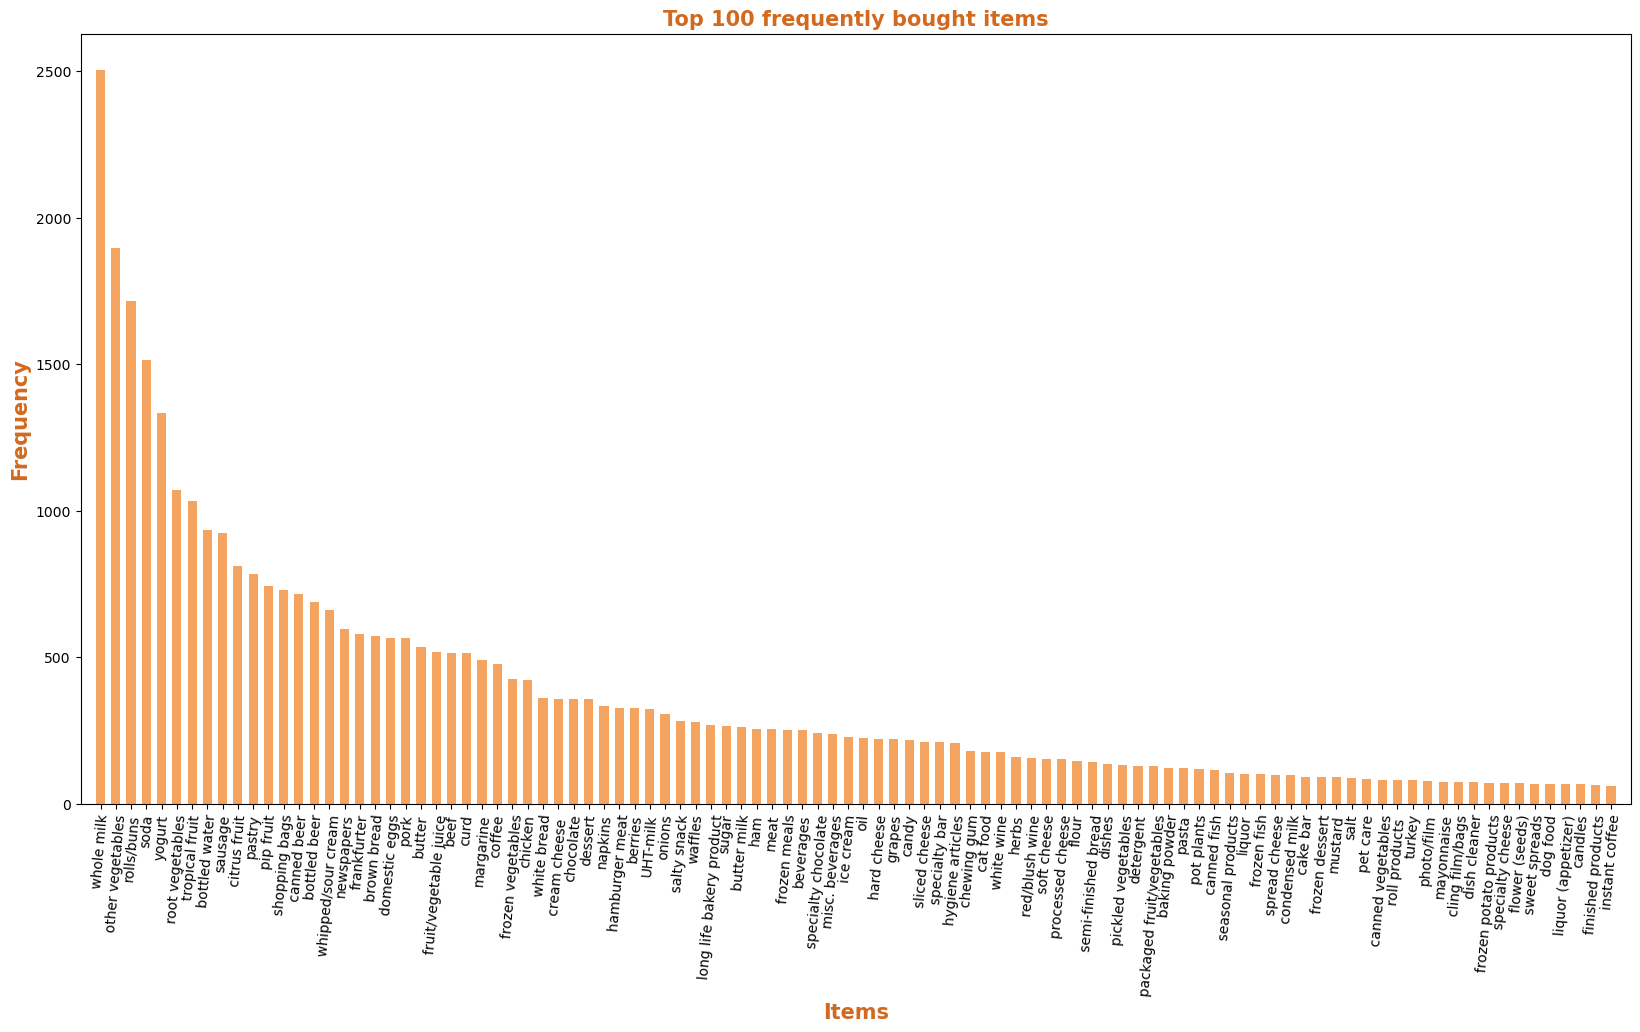

In [23]:
from matplotlib.pyplot import plot


def plot_bar_100(items, frequency):
    fig = plt.figure(figsize=(20, 10))
    plt.bar(items, frequency, align='center',width=0.6, color='sandybrown')
    plt.xticks(rotation=85)
    plt.gca().margins(x=0.01)
    plt.xlabel('Items', fontsize=15, fontweight='bold', color='chocolate')
    plt.ylabel('Frequency', fontsize=15, fontweight='bold', color='chocolate')
    plt.title('Top 100 frequently bought items', fontsize=15, fontweight='bold', color='chocolate')
    fig.show()
    return fig

fig = plot_bar_100([item[0] for item in items_with_frequency], [item[1] for item in items_with_frequency])

Saving to files

In [24]:
def write_top_100_unique_items_count(items_and_count,  **kwargs):
    folder_name = kwargs.get('folder_name')
    with open(f'{folder_name}/top_100_unique_items_count.txt', 'w') as f:
        f.write('The top 100 unique items and their count: \n')
        f.write('\n'.join([f'{item[0]}: {item[1]}' for item in items_and_count]))

def save_top_100_fig(fig,  **kwargs):
    folder_name = kwargs.get('folder_name')
    fig.savefig(f'{folder_name}/top_100_unique_items_count.png', bbox_inches='tight')
save_to_format(write_top_100_unique_items_count, items_with_frequency, folder_name='f2')
save_to_format(save_top_100_fig, fig, folder_name='f2')

### Task 1c: Find the number of baskets (of distinct items) for each customer

In [25]:
# Counting the number of baskets bought by a customer in a date
# TL;DR: A transaction made in a day (2nd col represented by 1 in py) 
#        by an individual unique customer (1st col represented by 0 in py ) is a basket
#        then use distinct() to deal with duplicates
user_baskets = basket_rdd_file.\
                map(lambda x: (x.split(',')[0], x.split(',')[1])).\
                map(lambda x: (x[0], x[1])).\
                distinct().\
                map(lambda x: (x[0], 1)).\
                reduceByKey(lambda x, y: x+y).\
                sortBy(lambda x: x[1], False).\
                take(100) 
logger.info(f'Top 10 frequent buyers: {user_baskets[:10]}')

C:\Users\fisha\AppData\Local\Temp\ipykernel_3036\3494955842.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


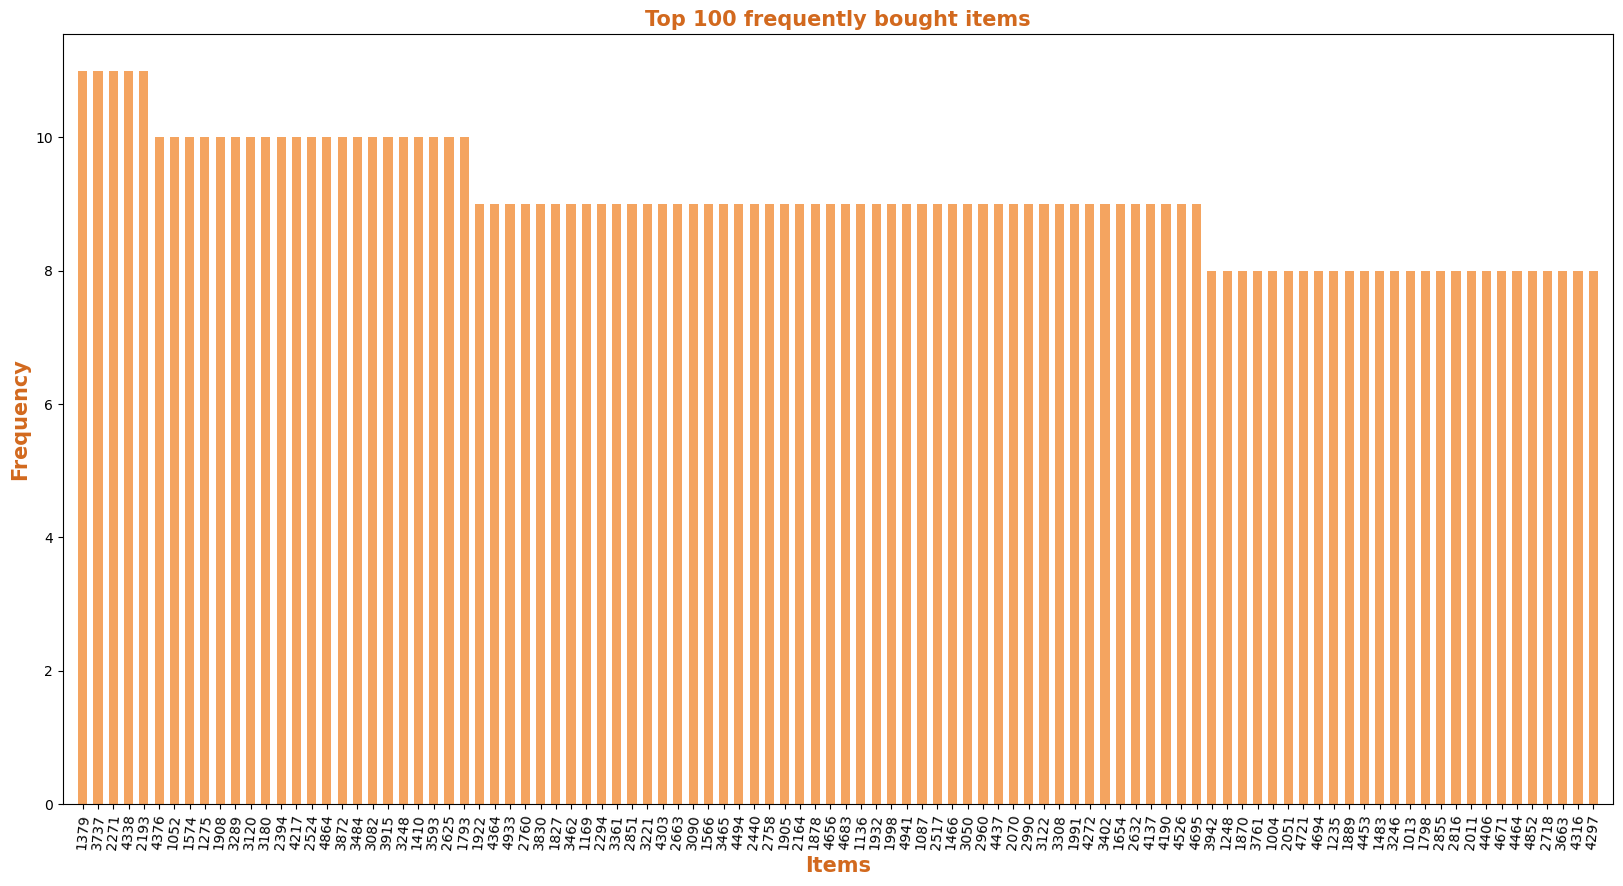

In [26]:
fig = plot_bar_100([item[0] for item in user_baskets], [item[1] for item in user_baskets])

In [27]:
def write_top_100_buyers(user_baskets, **kwargs):
    folder_name = kwargs.get('folder_name')
    with open(f'{folder_name}/top_100_buyers.txt', 'w') as f:
        f.write('The top 100 buyers and their count: \n')
        f.write('\n'.join([f'{user[0]}: {user[1]}' for user in user_baskets]))

save_to_format(write_top_100_buyers, user_baskets, folder_name='f3')
save_to_format(save_top_100_fig, fig, folder_name='f3')

### Task 1d: Find the items that is bought by the most distinct customers and vice versa

In [28]:
# Basically the same function but diff variable so let's make a factory function for it
# TL;DR: Read 2 columns, group by key to get distinct keys, they use set to get distinct values
#        after that just count and sort the rest, reverse the list to desc yada yada
def get_distinct_object_factory(type, basket_rdd_file):
    f_col = 99
    s_col = 99
    if type == 'items':
        f_col = 2
        s_col= 0
    elif type == 'buyers':
        f_col = 0
        s_col = 2

    return basket_rdd_file.map(lambda x: (x.split(',')[f_col], x.split(',')[s_col])).\
                            groupByKey().\
                            map(lambda x: (x[0], len(set(x[1])))).\
                            sortBy(lambda x: x[1], False).\
                            take(10)


In [29]:
# Finding the customer that bought the most distinct items
buyer_items_count =  get_distinct_object_factory('buyers', basket_rdd_file)
logger.info(f'Customer ID: {buyer_items_count[0][0]} bought the most distinct items: {buyer_items_count[0][1]}')

In [30]:
# Finding the item that was bought by the most distinct customers
item_bought_count = get_distinct_object_factory('items', basket_rdd_file)
logger.info(f'Item: {item_bought_count[0][0]} was bought by the most distinct customers: {item_bought_count[0][1]}')

In [31]:
def write_distinct_member_and_items(items_and_mem_count,  **kwargs):
    folder_name = kwargs.get('folder_name')
    with open(f'{folder_name}/distinct_member_and_items.txt', 'w') as f:
        f.write(f'The customer, with ID {items_and_mem_count[0][0][0]}, bought the most distinct items: {items_and_mem_count[0][0][1]} (items) \n')
        f.write(f'The item, named "{items_and_mem_count[1][0][0]}", was bought by the most distinct customers: {items_and_mem_count[1][0][1]} (customers) \n')

save_to_format(write_distinct_member_and_items, (buyer_items_count, item_bought_count), folder_name='f4')

## **Task 2: DF**

In [32]:
basket_df = sps.read.csv('baskets.csv', header=True, inferSchema=True)
basket_df.show(5)

+-------------+----------+----------------+----+-----+---+-----------+
|Member_number|      Date| itemDescription|year|month|day|day_of_week|
+-------------+----------+----------------+----+-----+---+-----------+
|         1249|01/01/2014|    citrus fruit|2014|    1|  1|          2|
|         1249|01/01/2014|          coffee|2014|    1|  1|          2|
|         1381|01/01/2014|            curd|2014|    1|  1|          2|
|         1381|01/01/2014|            soda|2014|    1|  1|          2|
|         1440|01/01/2014|other vegetables|2014|    1|  1|          2|
+-------------+----------+----------------+----+-----+---+-----------+
only showing top 5 rows



### Listing all baskets

In [33]:
from pyspark.sql import functions as F

# Using "collect_list" to "flatten" on duplicate id AND date (same basket), and agg obv to aggregate data
baskets = basket_df.\
            select('Member_number', 'Date', 'itemDescription').\
            groupBy('Member_number', 'Date').\
            agg(F.collect_set('itemDescription').alias('items')).\
            orderBy('Date').\
            withColumn('TID', F.monotonically_increasing_id()+1).\
            select('TID', 'Member_number', 'Date', 'items').\
            withColumnRenamed('Member_number', 'Member ID')
baskets.show(6, truncate=False) # Disabling text truncation aka trimming to show full col length

+---+---------+----------+----------------------------------------+
|TID|Member ID|Date      |items                                   |
+---+---------+----------+----------------------------------------+
|1  |1249     |01/01/2014|[citrus fruit, coffee]                  |
|2  |1381     |01/01/2014|[curd, soda]                            |
|3  |1440     |01/01/2014|[yogurt, other vegetables]              |
|4  |1659     |01/01/2014|[specialty chocolate, frozen vegetables]|
|5  |1789     |01/01/2014|[candles, hamburger meat]               |
|6  |1922     |01/01/2014|[tropical fruit, other vegetables]      |
+---+---------+----------+----------------------------------------+
only showing top 6 rows



### Find the number of baskets bought in each date

In [34]:
# Group the baskets by date and count all of the basket of the same date, and order by date as requested
basket_count_by_date = baskets.\
                        groupBy('Date').\
                        count().\
                        withColumnRenamed('count', 'Baskets count').\
                        orderBy('Date')
basket_count_by_date.show(6, truncate=False)

+----------+-------------+
|Date      |Baskets count|
+----------+-------------+
|01/01/2014|21           |
|01/01/2015|16           |
|01/02/2014|25           |
|01/02/2015|13           |
|01/03/2014|21           |
|01/03/2015|20           |
+----------+-------------+
only showing top 6 rows



In [35]:
# Spark can't save as json without hadoop and telling it to save as csv absolutely broke it
# While pandas' json output some weird format that isn't json, so pandas' csv works
save_to_format(baskets.toPandas().to_csv, './baskets/baskets.csv', folder_name='baskets',index=False)
save_to_format(basket_count_by_date.toPandas().to_csv, './baskets/baskets_count_by_date.csv', folder_name='baskets', index=False)

C:\Users\fisha\AppData\Local\Temp\ipykernel_3036\3346972752.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


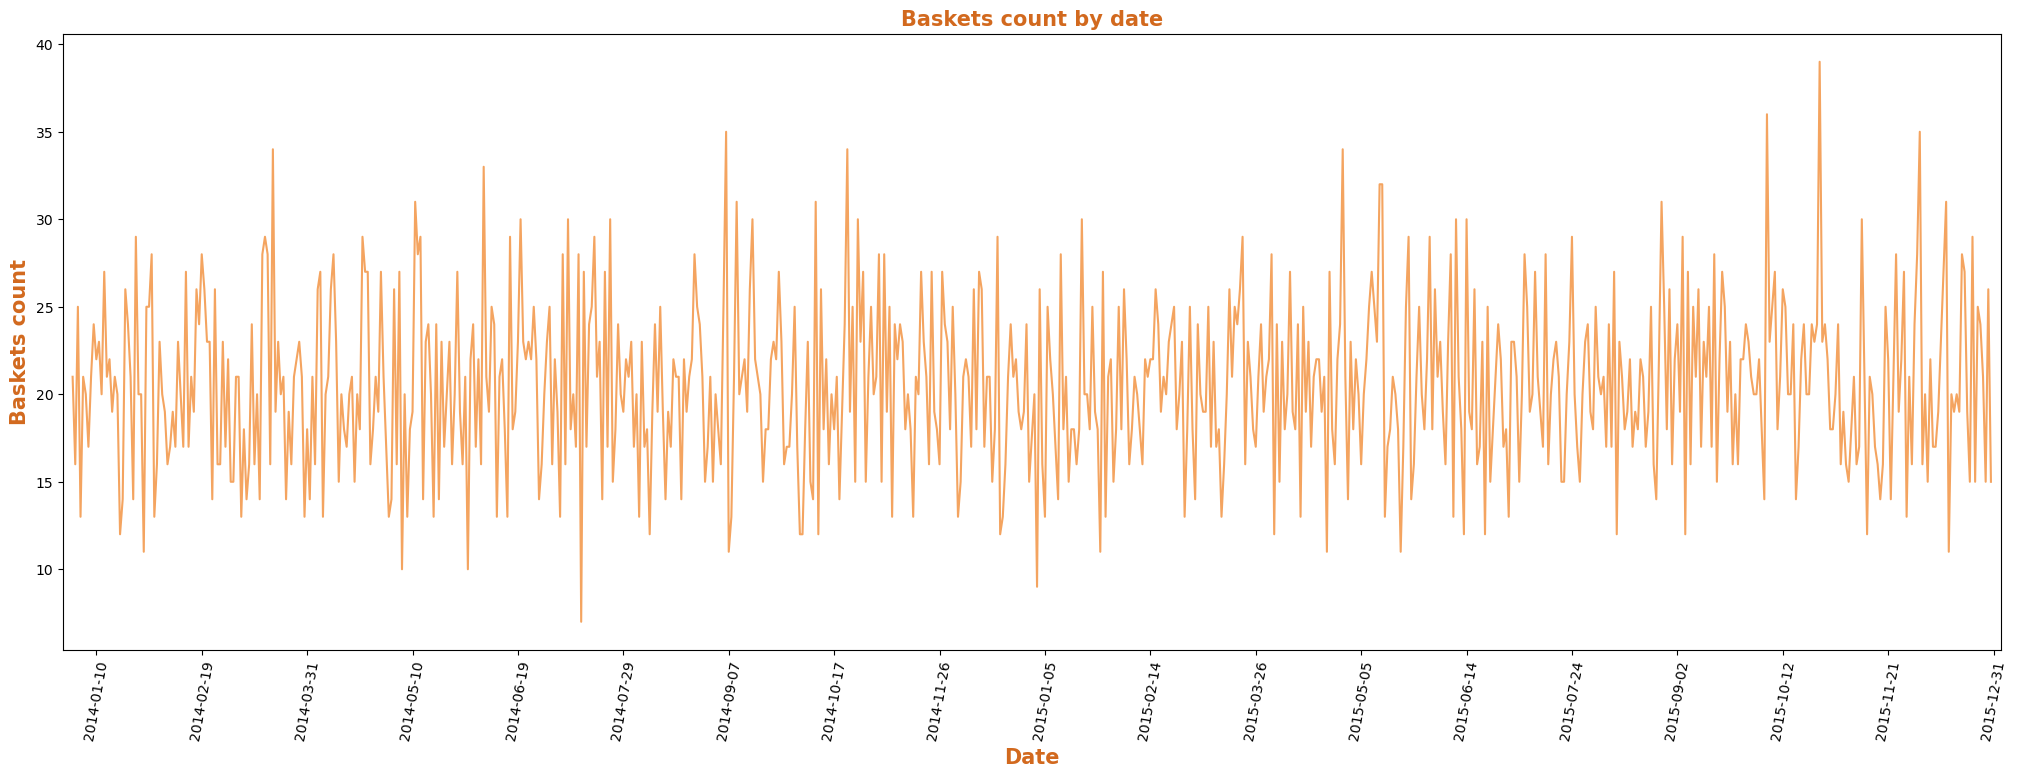

In [36]:
import pandas as pd

def draw_sales_figure(basket_count_by_date):
    fig = plt.figure(figsize=(25, 8))
    plt.plot(pd.to_datetime(basket_count_by_date.toPandas()['Date'],dayfirst=True).sort_values(), basket_count_by_date.toPandas()['Baskets count'], color='sandybrown')
    plt.xticks(rotation=80) 
    plt.gca().margins(x=0.005) # Scaling the figure
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(20)) # Limiting the number of x-axis ticks
    plt.xlabel('Date', fontsize=15, fontweight='bold', color='chocolate')
    plt.ylabel('Baskets count', fontsize=15, fontweight='bold', color='chocolate')
    plt.title('Baskets count by date', fontsize=15, fontweight='bold', color='chocolate')
    fig.show()
    return fig

fig = draw_sales_figure(basket_count_by_date)
save_to_format(fig.savefig, './baskets/baskets_count_by_date.png', folder_name='baskets', bbox_inches='tight')

## **Task 3: PCY**

Defining items

In [37]:
items = baskets.select('items')
items.show(5)

+--------------------+
|               items|
+--------------------+
|[yogurt, other ve...|
|        [curd, soda]|
|[citrus fruit, co...|
|[specialty chocol...|
|[candles, hamburg...|
+--------------------+
only showing top 5 rows



Defining support threshold

In [38]:
support = 0.005

Defining the PCY class

In [39]:
from itertools import combinations
from pyspark.sql.functions import col

class PCY:
    def __init__(self, threshold=0):
        self.threshold = threshold
        self.minsup = 0
        self.frequent_pairs = {}

    def set_threshold(self, threshold):
        self.threshold = threshold 
    def __transform_baskets_to_tables_with_id(self, baskets):
        return baskets.withColumn('id', F.monotonically_increasing_id()).select('id', F.explode('items').alias('items'))

    def __filter_transactions(self, transaction_table):
        frequent_items = transaction_table.groupBy('items').count().filter(F.col('count') > self.minsup)
        return transaction_table.join(frequent_items, 'items', 'inner').select('id', 'items')
    
    def __filter_pairs_old(self, pairs):
        return pairs.filter(lambda x: x[1] > self.minsup)

    @staticmethod
    def hash_function(item1, item2, val):
        return (item1 + item2) % val
    
    def __filter_pairs(self, pairs):
        pairs = pairs.map(lambda x: [(x[0][0], x[0][1]), x[1]])
        pairs_table = (pairs.toDF(['pairs', 'count'])
                       .select(col('pairs._1').alias('item1'), 
                               col('pairs._2').alias('item2'),
                              'count')
        )   

        Hash_Table = (pairs_table
                      .withColumn('Bucket Num', self.hash_function(F.col('item1'), F.col('item2'), 10))
                      .select('Bucket Num', 'count', F.array('item1', 'item2').alias('pair'))
                      .groupBy('Bucket Num')
                      .agg(F.sum('count').alias('count'), F.collect_list('pair').alias('pairs'))
                      .filter(F.col('count') > self.minsup)
                    )
        
        Candidate_Pairs_raw = (Hash_Table
                           .select(F.explode('pairs').alias('pairs'))
        )

        pairs_count = (
            pairs_table.withColumn('pair', F.array('item1', 'item2'))
            .drop('item1', 'item2')
        )

        Candidate_Pairs_raw = (Candidate_Pairs_raw.join(pairs_count, Candidate_Pairs_raw.pairs == pairs_count.pair, 'left')
                            .drop('pair')
                            )
        
        Candidate_pairs = Candidate_Pairs_raw.filter(Candidate_Pairs_raw["count"] > self.minsup)
        return (Candidate_pairs
                    .withColumnRenamed('pairs','items')
                    .withColumnRenamed('count', 'frequency')
                )
    

        

    
    def get_frequent_pairs(self, baskets, support_threshold=0.005):
        if self.threshold == 0:
            self.threshold = support_threshold
        
        self.minsup = self.threshold * baskets.count()
        logger.info(f'Min support: {self.minsup}')
        # Exploding the basket lists to a table with items and its corresponding id of the transaction            
        transaction_table = self.__filter_transactions(self.__transform_baskets_to_tables_with_id(baskets))

        pairs = (transaction_table
                .groupBy('id')
                .agg(F.collect_set('items').alias('items'))
                .select('items')
                .rdd
                .flatMap(lambda x: combinations(x[0], 2))
                .map(lambda x: (x, 1))
                .reduceByKey(lambda x, y: x+y)
        )
        

        return self.__filter_pairs(pairs)

Running the PCY algorithm

In [41]:
import os

pcy = PCY()
frequent_pairs = pcy.get_frequent_pairs(baskets.select('items'), support)
print(f'Support threshold: {pcy.minsup}')
print(f'Pair count: {frequent_pairs.count()}')
frequent_pairs.show(5)
(frequent_pairs
    # .toPandas()
    # .to_csv('PCY Results/pcy_frequent_pairs.csv', index=False)
    .withColumn("items", F.concat_ws(",", "items"))
    .write.csv('PCY Results/pcy_frequent_pairs.csv', header=True, mode='overwrite')
)

Support threshold: 74.815
Pair count: 36
+--------------------+---------+
|               items|frequency|
+--------------------+---------+
|[soda, tropical f...|       81|
|[whole milk, citr...|      107|
|[yogurt, tropical...|       78|
|      [yogurt, soda]|       87|
|[rolls/buns, trop...|       91|
+--------------------+---------+
only showing top 5 rows

